https://github.com/asimniazi63/semantic-segnmentation

In [1]:
import torch

import numpy as np
import platform
#import SarFileIO as sarIO
import os
import scipy.io as scio

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rasterio
import glob
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
import math
import rasterio as rio
#from osgeo import osr, ogr, gdal, gdal_array
import os
import tarfile
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
#from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
import numpy as np
from numpy import load
import scipy.io as scio

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Performance Metrices


In [2]:
#metrics
#import keras.backend as K
def dice_coef(y_true, y_pred, smooth=1):
  
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def _recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def _precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = _precision(y_true, y_pred)
    recall = _recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_loss(y_true, y_pred):
  return 1 - f1_score(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [3]:
def read_band_image(band, path):
    """
    This function takes as input the Sentinel-2 band name and the path of the 
    folder that the images are stored, reads the image and returns the data as
    an array
    input:   band           string            Sentinel-2 band name
             path           string            path of the folder
    output:  data           array (n x m)     array of the band image
             spatialRef     string            projection 
             geoTransform   tuple             affine transformation coefficients
             targetprj                        spatial reference
    """
    a = path+'*B'+band+'*.jp2'
    img = gdal.Open(glob.glob(a)[0])
    data = np.array(img.GetRasterBand(1).ReadAsArray())
    spatialRef = img.GetProjection()
    geoTransform = img.GetGeoTransform()
    targetprj = osr.SpatialReference(wkt = img.GetProjection())
    return data, spatialRef, geoTransform, targetprj




def array2raster(array, geoTransform, projection, filename):
    """ 
    This function tarnsforms a numpy array to a geotiff projected raster
    input:  array                       array (n x m)   input array
            geoTransform                tuple           affine transformation coefficients
            projection                  string          projection
            filename                    string          output filename
    output: dataset                                     gdal raster dataset
            dataset.GetRasterBand(1)                    band object of dataset
    
    """
    pixels_x = array.shape[1]
    pixels_y = array.shape[0]
    
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(
        filename,
        pixels_x,
        pixels_y,
        1,
        gdal.GDT_Float64, )
    dataset.SetGeoTransform(geoTransform)
    dataset.SetProjection(projection)
    dataset.GetRasterBand(1).WriteArray(array)
    dataset.FlushCache()  # Write to disk.
    return dataset, dataset.GetRasterBand(1)  #If you need to return, remenber to return  also the dataset because the band don`t live without dataset.
 
def clip_raster(filename, shp):
    """
    This function clips a raster based on a shapefile
    input:  filename          string                input raster filename
            shp               dataframe             input shapefile open with geopandas
    output: clipped           array (1 x n x m)     clipped array 
            clipped_meta      dict                  metadata
            cr_ext            tuple                 extent of clipped data
            gt                tuple                 affine transformation coefficients
    """
    inraster = rasterio.open(filename)
    
    extent_geojson = mapping(shp['geometry'][0])
    clipped, crop_affine = mask(inraster, 
                                shapes=[extent_geojson], 
                                nodata = np.nan,
                                crop=True)
    clipped_meta = inraster.meta.copy()
    # Update the metadata to have the new shape (x and y and affine information)
    clipped_meta.update({"driver": "GTiff",
                 "height": clipped.shape[0],
                 "width": clipped.shape[1],
                 "transform": crop_affine})
    cr_ext = rasterio.transform.array_bounds(clipped_meta['height'], 
                                            clipped_meta['width'], 
                                            clipped_meta['transform'])
    
    # transform to gdal
    gt = crop_affine.to_gdal()
    
    return clipped, clipped_meta, cr_ext, gt
    
def reclassify(array):
    """
    This function reclassifies an array
    input:  array           array (n x m)    input array
    output: reclass         array (n x m)    reclassified array
    """
    reclass = np.zeros((array.shape[0],array.shape[1]))
    for i in range(0,array.shape[0]):
        for j in range(0,array.shape[1]):
            if math.isnan(array[i,j]):
                reclass[i,j] = np.nan
            elif array[i,j] < 0.1:
                reclass[i,j] = 1
            elif array[i,j] < 0.27:
                 reclass[i,j] = 2
            elif array[i,j] < 0.44:
                 reclass[i,j] = 3
            elif array[i,j] < 0.66:
                 reclass[i,j] = 4
            else:
                reclass[i,j] = 5
                
    return reclass

In [4]:
def read_band_image(path,dronedata):
    """
    This function takes as input the ldrone image and the path of the 
    folder that the images are stored, reads the image and returns the data as
    an array
    input:   drone          drone image
             path           string            path ,of the folder
    output:  data           array (n x m)     array of the band image
             spatialRef     string            projection 
             geoTransform   tuple             affine transformation coefficients
             targetprj                        spatial reference
    """
    import os
    from osgeo import osr, gdal, gdal_array

    #img_ds = rio.open(r'T:\Aktive\DSU\3434\52232_Barkbilleskader_S_2\aux_data' + r'\dtm16m_utm32.tif')
    #img_ds1 = rio.open(path + dronedata)
    
    os.chdir(path)
    os.getcwd()
    #img_ds = gdal.Open(glob.glob(a)[0])
    img_ds = gdal.Open(dronedata, gdal.GA_ReadOnly)


    # gdal_rasterize -a HKL_VERDI -ot Float32 -of GTiff  -tr 20 20 -te 591964.4892070280620828 6607127.0049451533704996 609364.4892070280620828 6627967.0049451533704996  -l SKOGBRUKSPLAN_BESTAND_FLATE_0214_d5685 SKOGBRUKSPLAN_BESTAND_FLATE_0214_d5685.shp SKOGBRUKSPLAN_BESTAND_FLATE_0214_d5685_hklverdi.tif
    data = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
                   gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

    for b in range(data.shape[2]):
        data[:, :, b] = np.array(img_ds.GetRasterBand(b + 1).ReadAsArray())


    
    spatialRef = img_ds.GetProjection()
    geoTransform = img_ds.GetGeoTransform()
    targetprj = osr.SpatialReference(wkt = img_ds.GetProjection())
    return data, spatialRef, geoTransform, targetprj



def CreateGeoTiff(Name, Array, DataType, NDV,bandnames=None,ref_image=None,GeoT=None, Projection=None):
# If it's a 2D image we fake a third dimension:
    if len(Array.shape)==2:
        Array=np.array([Array])
    if ref_image==None and (GeoT==None or Projection==None):
        raise RuntimeWarning('ref_image or settings required.')
    if bandnames != None:
        if len(bandnames) != Array.shape[0]:
            raise RuntimeError('Need {} bandnames. {} given'
                .format(Array.shape[0],len(bandnames)))
    else:
        bandnames=['Band {}'.format(i+1) for i in range(Array.shape[0])]
    if ref_image!= None:
        refimg=gdal.Open(ref_image)
        GeoT=refimg.GetGeoTransform()
        Projection=refimg.GetProjection()
    driver= gdal.GetDriverByName('GTIFF')
    Array[np.isnan(Array)] = NDV
    DataSet = driver.Create(Name,Array.shape[2],Array.shape[1],Array.shape[0],DataType)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection)
    for i, image in enumerate(Array, 1):
        DataSet.GetRasterBand(i).WriteArray( image )
        DataSet.GetRasterBand(i).SetNoDataValue(NDV)
        DataSet.SetDescription(bandnames[i-1])
    DataSet.FlushCache()
    return Name

In [5]:
def read_band_image(path,dronedata):
    """
    This function takes as input the ldrone image and the path of the 
    folder that the images are stored, reads the image and returns the data as
    an array
    input:   drone          drone image
             path           string            path ,of the folder
    output:  data           array (n x m)     array of the band image
             spatialRef     string            projection 
             geoTransform   tuple             affine transformation coefficients
             targetprj                        spatial reference
    """
    import os
    import rasterio

    
    os.chdir(path)
    os.getcwd()
    img_ds=rasterio.open(dronedata)
    data = np.zeros((img_ds.height, img_ds.width, img_ds.count))
                   

    for b in range(data.shape[2]):
        data[:, :, b] = np.array(img_ds.read(b+1))
        
    


    
    crs=img_ds.crs
    
    geoTransform = img_ds.transform
    return data, crs, geoTransform

In [161]:
dataset_path = '.\Kerala'

year=2022
month='May'
site='SITE2'
path = r'/space/vak/Weedwatch/Kerala/'
outputpath= r'/space/vak/Weedwatch/Kerala/Patches/Site3_128_5cm'

# Paths

#if site=='SITE3':
    
inputfile1='Drone/OrthoSite3_utm_5cm.tif'
GTfile1='gt/site3_utm_5cm.tif'


inputfile2='Drone/OrthoSite2_utm_5cm.tif'
GTfile2='gt/Kerala2_May_GT_ras.tif'
   
    
# Read drone bands 
(dronedata1, crs1, geoTransform1) = read_band_image(path,inputfile1)
(dronedata2, crs2, geoTransform2) = read_band_image(path,inputfile2)


    
# Read drone bands


(cls1,crs1, geoTransform1) = read_band_image(path,GTfile1)
(cls2, crs2, geoTransform2) = read_band_image(path,GTfile2)




In [162]:
dronedata2.shape, cls2.shape

((11638, 16493, 11), (11638, 16493, 1))

In [163]:
dronedata1.shape, cls1.shape

((11806, 4726, 11), (11806, 4726, 1))

In [164]:
cls2[cls2 == 7]= 2
dronedata1=np.uint8(dronedata1)
cls1=np.uint8(cls1)
mask1=dronedata1[:,:,10]


dronedata2=np.uint8(dronedata2)
cls2=np.uint8(cls2)
mask2=dronedata2[:,:,10]


In [165]:
# next setup a colormap for our map
colors = dict((
    (0, (255, 255, 255, 255)),   # White - NO Data
    (1, (0,0,255, 255)),      # Blue - Water
    (2, (0, 240, 0, 255))   # Purple - Emergent Wetland
       ))




n=5
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

In [166]:
def visRGB(img1, img2, img3,
           title = 'RGB image',
           scale1 = [],
           scale2 = [],
           scale3 = [],
           flag = 0, outall = ''):
    """
    Visualise the RGB of a single acquisition
    """           
    if scale1 == []:
       scale1 = img1
    if scale2 == []:
       scale2 = img2
    if scale3 == []:
       scale3 = img3

    size = np.shape(img1)           
    iRGB = np.zeros([size[0],size[1],3])
    iRGB[:,:,0] = np.abs(img1)/(np.abs(scale1).mean()*1.5)
    iRGB[:,:,1] = np.abs(img2)/(np.abs(scale2).mean()*1.5)
    iRGB[:,:,2] = np.abs(img3)/(np.abs(scale3).mean()*1.5)
    iRGB[np.abs(iRGB) > 1] = 1
            
#    plt.figure()

    fig = plt.figure(figsize=(8,8))
    ax2 = fig.add_subplot(1,1,1)
    plot = plt.imshow(iRGB); 
    plt.title('(RGB image)'); 
    cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
    cbar.set_label('Reflectance',rotation=90,labelpad=20); 
    ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
    rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

    if flag == 1:
        fig.savefig(outall)

    return       
           

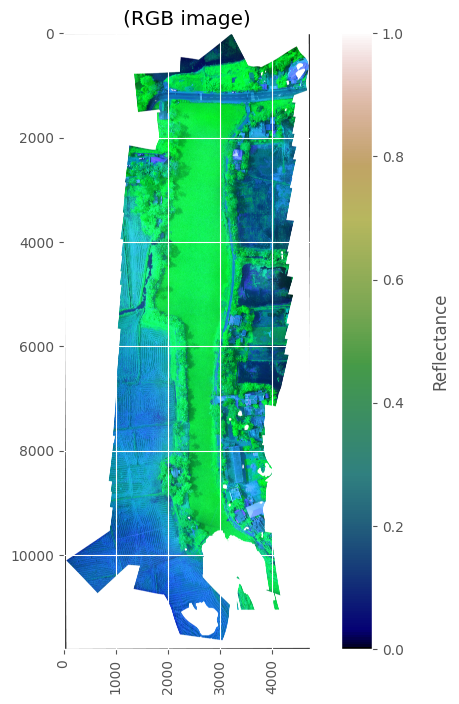

In [167]:
visRGB(dronedata1[:,:,0], dronedata1[:,:,9], dronedata1[:,:,1],
           title = 'RGB image',
           scale1 = [0,255],
           scale2 = [0,255],
           scale3 = [0,255],
           flag = 0, outall = '')

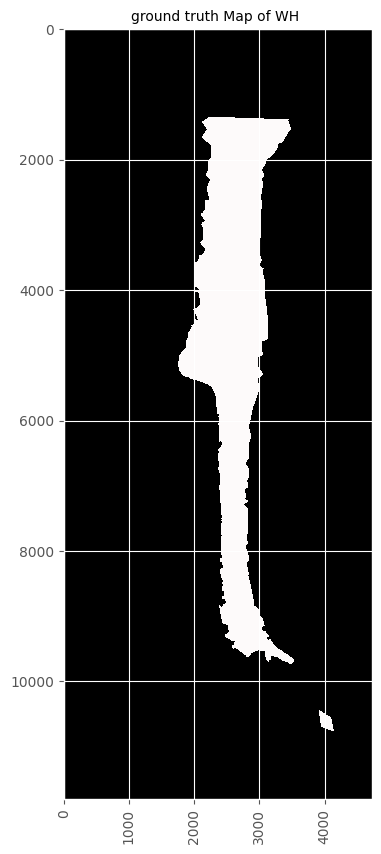

In [168]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls1, interpolation='none'); 
ax1.set_title('ground truth Map of WH ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees


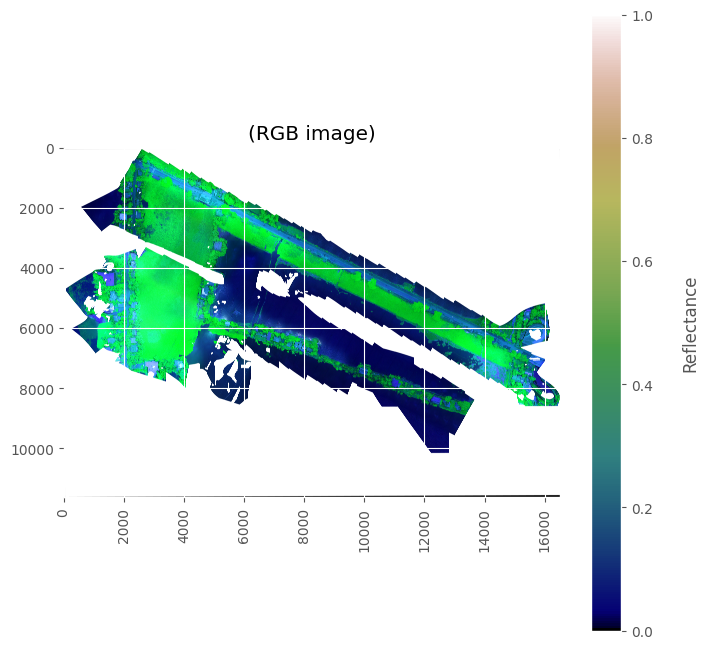

In [169]:
visRGB(dronedata2[:,:,0], dronedata2[:,:,9], dronedata2[:,:,1],
           title = 'RGB image',
           scale1 = [0,255],
           scale2 = [0,255],
           scale3 = [0,255],
           flag = 0, outall = '')

In [170]:
dronedata2.shape

(11638, 16493, 11)

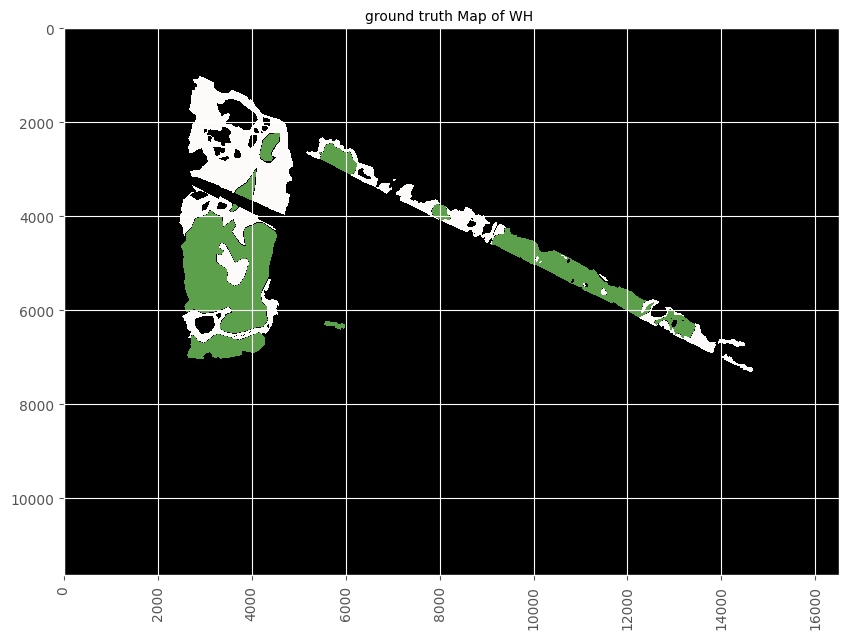

In [171]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls2, interpolation='none'); 
ax1.set_title('ground truth Map of WH ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees


In [172]:
!pip install EMPatches


/bin/bash: /home/vak/anaconda3/envs/myenv/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [173]:
dronedata1.shape

(11806, 4726, 11)

In [174]:
from empatches import EMPatches
sample_step = 512
sample_size = 512

Nchannels=4


# load module
emp = EMPatches()
if Nchannels==10:
    X1, indices1 = emp.extract_patches(dronedata1[:, :, :10], patchsize=sample_size, overlap=0)
    y1,indices1  = emp.extract_patches(cls1, patchsize=sample_size, overlap=0)
    X2, indices2 = emp.extract_patches(dronedata2[:, :10000, :10], patchsize=sample_size, overlap=0)
    y2,indices2  = emp.extract_patches(cls2[:, :10000, :], patchsize=sample_size, overlap=0)

else:
    data1 = np.zeros((dronedata1.shape[0], dronedata1.shape[1], Nchannels))

    # Band2, Band 4, Band 7, Band 10 from drone
    data1[:, :, 0]= dronedata1[:, :, 1]
    data1[:, :, 1]= dronedata1[:, :, 3]
    data1[:, :, 2]= dronedata1[:, :, 6]
    data1[:, :, 3]= dronedata1[:, :, 9]
    X1, indices1 = emp.extract_patches(data1, patchsize=sample_size, overlap=0)
    y1,indices1  = emp.extract_patches(cls1, patchsize=sample_size, overlap=0)
    
    
    data2 = np.zeros((dronedata2.shape[0], dronedata2.shape[1], Nchannels))

    # Band2, Band 4, Band 7, Band 10 from drone
    data2[:, :, 0]= dronedata2[:, :, 1]
    data2[:, :, 1]= dronedata2[:, :, 3]
    data2[:, :, 2]= dronedata2[:, :, 6]
    data2[:, :, 3]= dronedata2[:, :, 9]
    X2, indices2 = emp.extract_patches(data2, patchsize=sample_size, overlap=0)
    y2,indices2  = emp.extract_patches(cls2, patchsize=sample_size, overlap=0)
    

    
    
    
    
X1=np.array(X1)
y1=np.array(y1)
X2=np.array(X2)
y2=np.array(y2)

X=np.concatenate((X1, X2), axis=0)
y=np.concatenate((y1, y2), axis=0)

print('Loaded: ', X1.shape, y1.shape, X2.shape, y2.shape, X.shape, y.shape)


Loaded:  (240, 512, 512, 4) (240, 512, 512, 1) (759, 512, 512, 4) (759, 512, 512, 1) (999, 512, 512, 4) (999, 512, 512, 1)


In [175]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15232926002511420093
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 510197760
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6256484584361268538
physical_device_desc: "device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:17:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2023-05-05 09:53:59.661609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2006] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GT 710, pci bus id: 0000:65:00.0, compute capability: 3.5) with core count: 1. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2023-05-05 09:53:59.663141: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 486 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:17:00.0, compute capability: 7.5


In [6]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.python.keras.activations import relu
import random 

2023-05-18 08:48:23.064227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [177]:

from sklearn.model_selection import train_test_split
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



(699, 512, 512, 4) (699, 512, 512, 1) (300, 512, 512, 4) (300, 512, 512, 1)


223


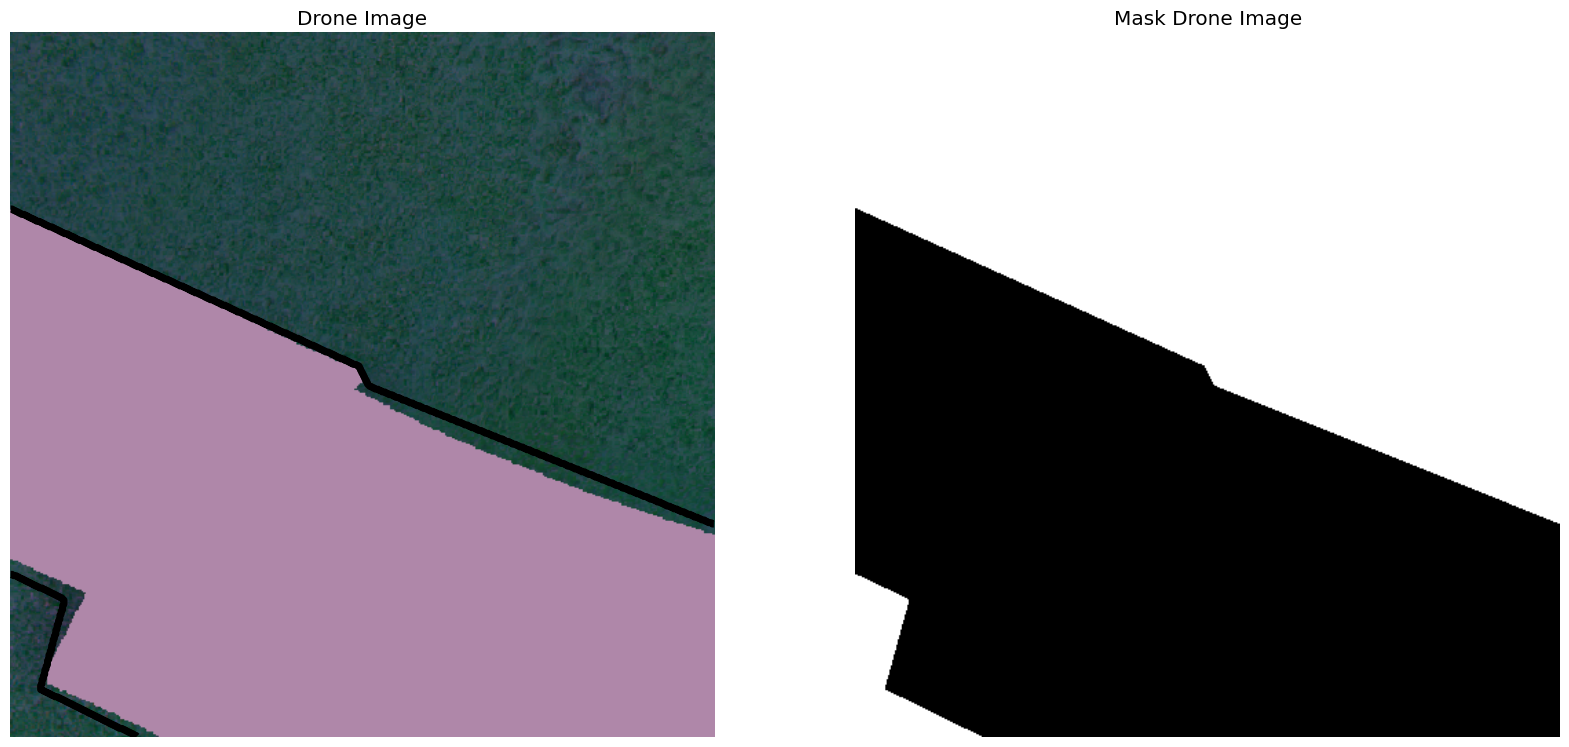

In [178]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

print(ix)
srcim=X_train[ix]
size = np.shape(srcim) 

size = np.shape(srcim)     # this function tell us the size of VV1, we need this 
iRGB = np.zeros([size[0],size[1],3])    # create the 3D container
iRGB[:,:,0] = np.abs(srcim[:,:,0])/(np.abs(srcim[:,:,0]).mean()*2.5)
iRGB[:,:,1] = np.abs(srcim[:,:,3])/(np.abs(srcim[:,:,3]).mean()*2.5)
iRGB[:,:,2] = np.abs(srcim[:,:,1])/(np.abs(srcim[:,:,2]).mean()*2.5)
iRGB[np.abs(iRGB) > 1] = 1
    
 #ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
ax1.imshow(iRGB, interpolation = 'bilinear')

if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Drone Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Drone Image')
ax2.set_axis_off()

In [15]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [16]:
def Unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(2, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [181]:
tf.test.is_gpu_available()

2023-05-05 09:54:26.038707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2006] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GT 710, pci bus id: 0000:65:00.0, compute capability: 3.5) with core count: 1. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2023-05-05 09:54:26.040088: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 486 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:17:00.0, compute capability: 7.5


True

In [17]:
from keras import backend as K
K.clear_session()

Nchannels=X.shape[3]
input_img = Input((sample_size, sample_size, Nchannels), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
metrics = ["accuracy", 
           dice_coef,f1_score,_recall,_precision,
           tf.keras.metrics.AUC(),
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]


model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

NameError: name 'X' is not defined

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  736         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 activation_13 (Activation)     (None, 16, 16, 256)  0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_13 (Conv2D)             (None, 16, 16, 256)  590080      ['activation_12[0][0]']          
                                                                                                  
 add_4 (Add)                    (None, 16, 16, 256)  0           ['activation_13[0][0]',          
                                                                  'conv2d_13[0][0]']              
                                                                                                  
 activation_14 (Activation)     (None, 16, 16, 256)  0           ['add_4[0][0]']                  
                                                                                                  
 conv2d_15

 up_sampling2d_3 (UpSampling2D)  (None, 256, 256, 64  0          ['add_7[0][0]']                  
                                )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 80  0           ['up_sampling2d_3[0][0]',        
                                )                                 'add[0][0]']                    
                                                                                                  
 activation_25 (Activation)     (None, 256, 256, 80  0           ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_26 (Conv2D)             (None, 256, 256, 32  23072       ['activation_25[0][0]']          
          

In [184]:
!pip install visualkeras


/bin/bash: /home/vak/anaconda3/envs/myenv/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [28]:
locate .ttf

NameError: name 'locate' is not defined

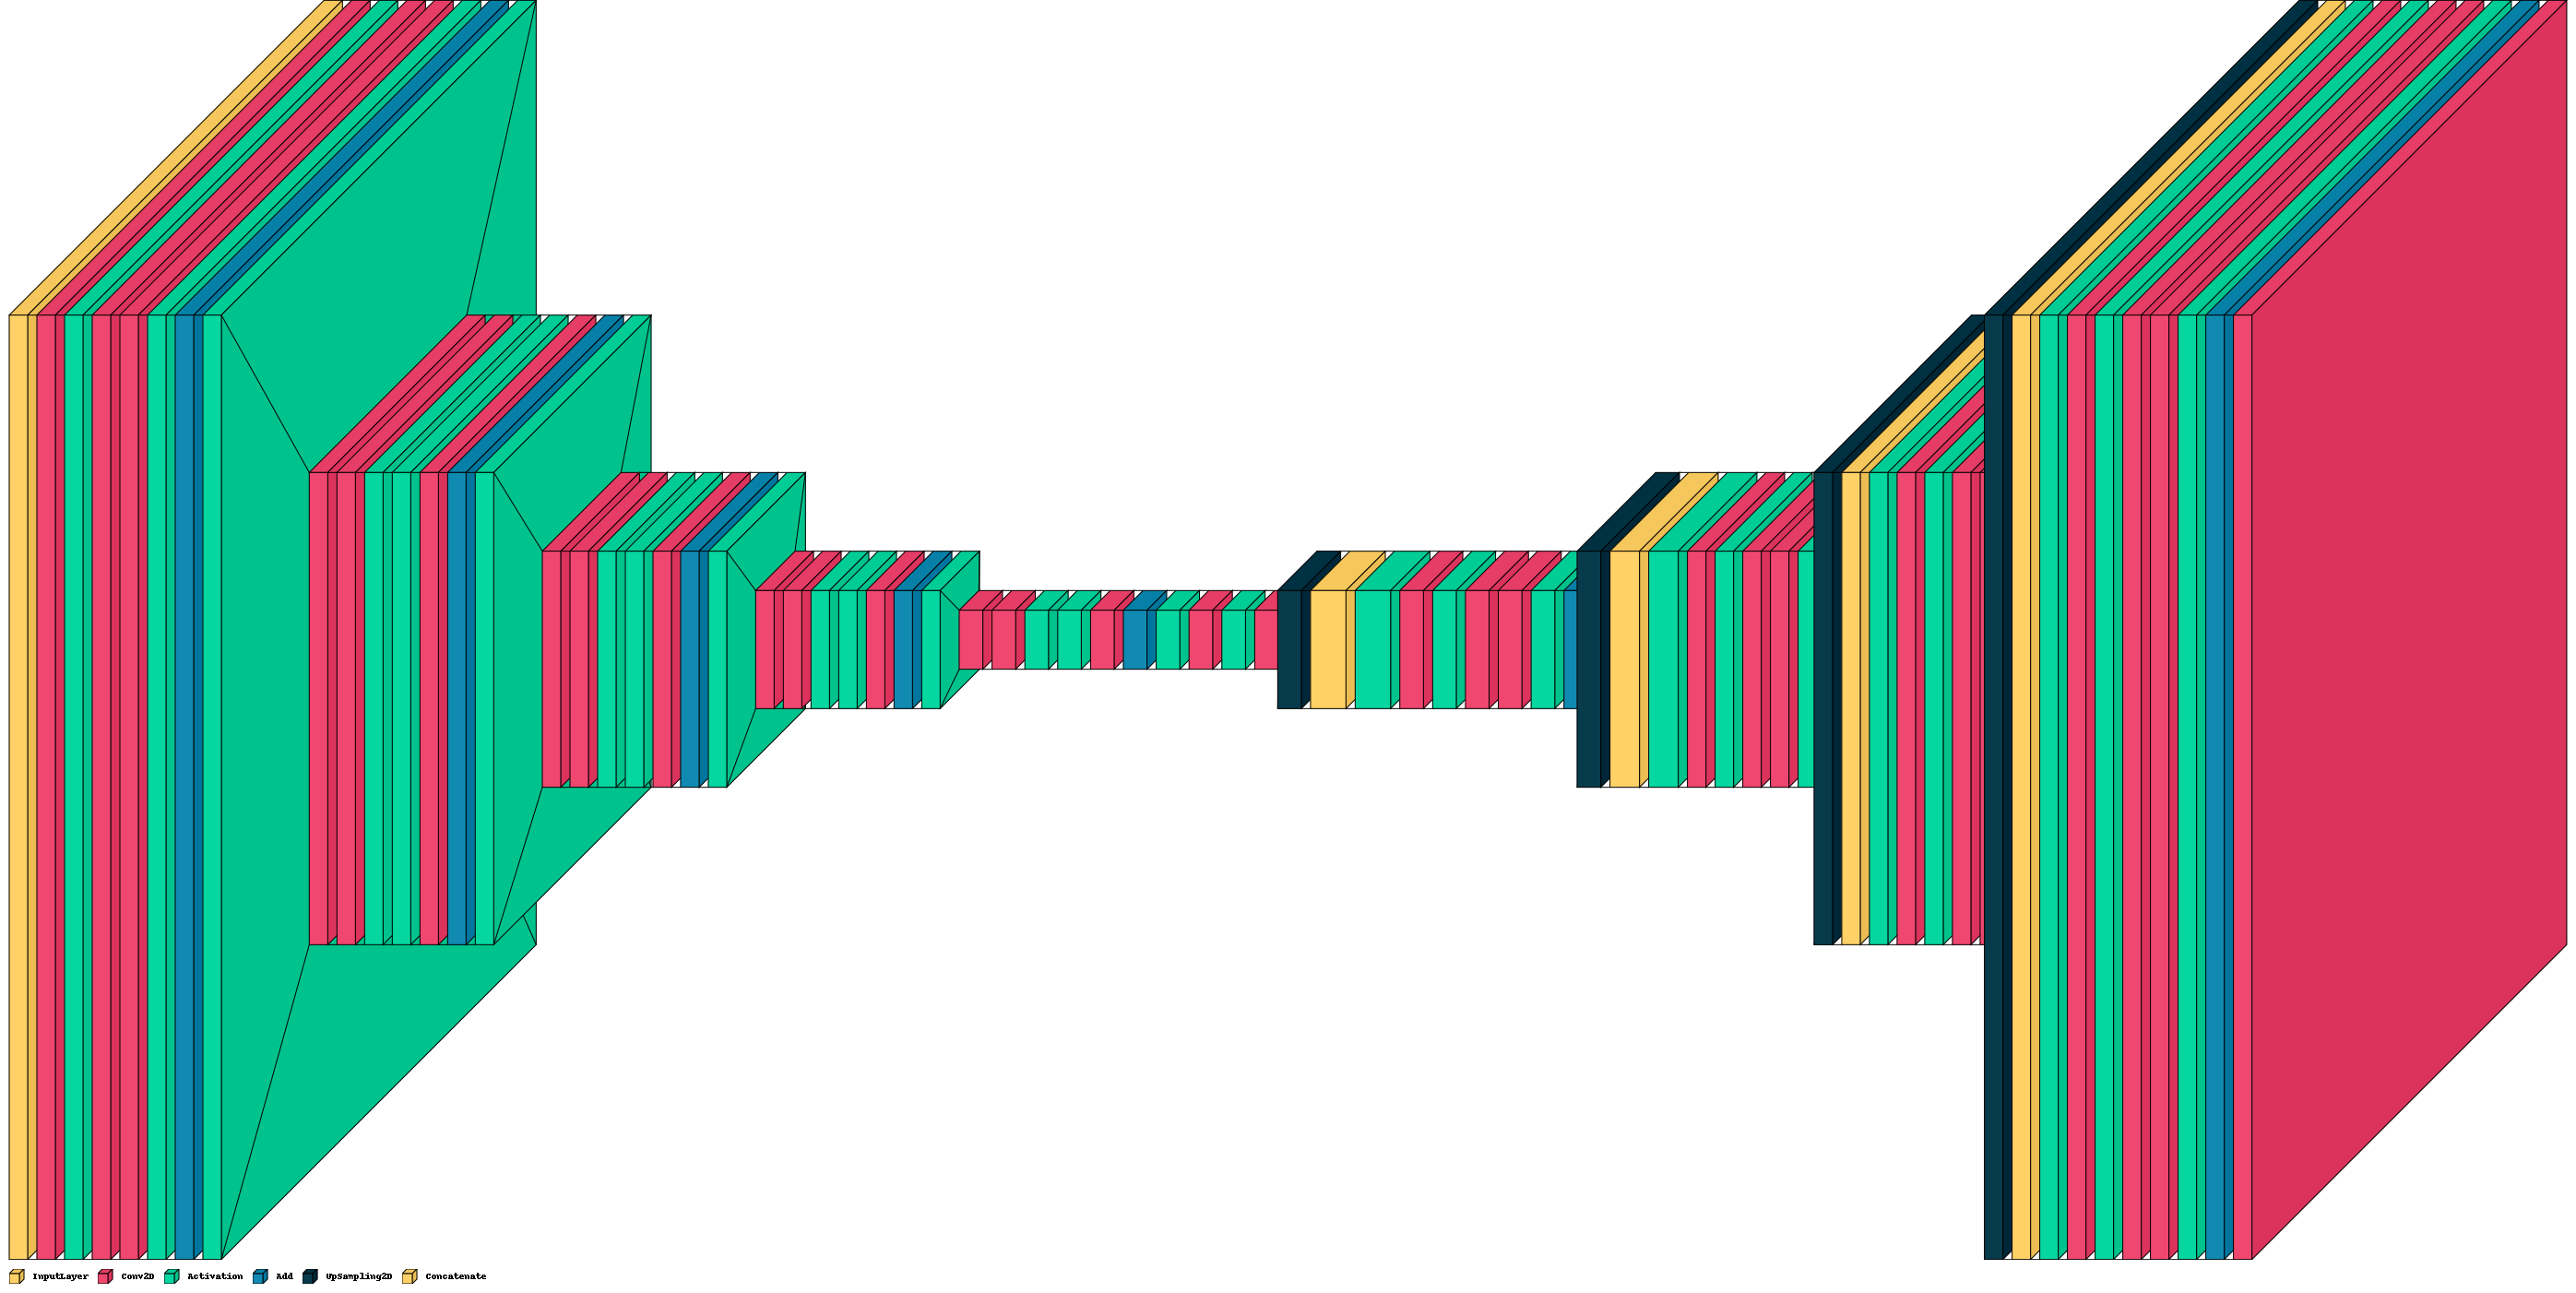

In [29]:
from PIL import ImageFont


visualkeras.layered_view(model, legend=True)  # font is optional!


In [186]:

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet_4ch.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataUnet_4ch.csv"),
    TensorBoard(log_dir='./logs')
]

In [187]:

import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

cuda_malloc_async


In [188]:
results = model.fit(X_train, y_train, batch_size=3, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

2023-05-05 09:54:50.851978: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.73GiB (rounded to 2931818496)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-05 09:54:50.852063: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-05-05 09:54:50.852090: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 89, Chunks in use: 89. 22.2KiB allocated for chunks. 22.2KiB in use in bin. 9.4KiB client-requested in use in bin.
2023-05-05 09:54:50.852105: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 10.5KiB allocated for chunks. 10.5KiB in use in bin. 10.5KiB client-requested in use in bin.
2023-05-05 09:54:50.852121: I tensorflow/tsl/frame

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

sl/framework/bfc_allocator.cc:1090] InUse at 7f8d80002c00 of size 256 next 77
2023-05-05 09:54:50.852614: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f8d80002d00 of size 512 next 81
2023-05-05 09:54:50.852623: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f8d80002f00 of size 512 next 99
2023-05-05 09:54:50.852630: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f8d80003100 of size 512 next 93
2023-05-05 09:54:50.852637: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f8d80003300 of size 512 next 97
2023-05-05 09:54:50.852645: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f8d80003500 of size 512 next 115
2023-05-05 09:54:50.852652: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f8d80003700 of size 512 next 116
2023-05-05 09:54:50.852659: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f8d80003900 of size 512 next 45
2023-05-05 09:54:50.852666: I tensorflow/tsl/framework/bfc_allocator.cc:1090] In

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

In [ ]:


df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result



In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve/4ch")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve74ch")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Acc")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Acc")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Acc")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
model.load_weights('model-Unet_10ch.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    srcim=X[ix]
    size = np.shape(srcim) 
    
    size = np.shape(srcim)     # this function tell us the size of VV1, we need this 
    iRGB = np.zeros([size[0],size[1],3])    # create the 3D container
    iRGB[:,:,0] = np.abs(srcim[:,:,0])/(np.abs(srcim[:,:,0]).mean()*2.5)
    iRGB[:,:,1] = np.abs(srcim[:,:,4])/(np.abs(srcim[:,:,1]).mean()*2.5)
    iRGB[:,:,2] = np.abs(srcim[:,:,1])/(np.abs(srcim[:,:,2]).mean()*2.5)
    iRGB[np.abs(iRGB) > 1] = 1
    

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    #ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    ax[0].imshow(iRGB, cmap='seismic')

    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Drone Image')
    ax[0].set_axis_off()

     
    
    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Drone Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Drone Image Predicted')
    ax[2].set_axis_off()
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Drone Mask Image Predicted binary');
    ax[3].set_axis_off()    

# Predictions on training set


In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=154)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
# Predict on train, val and test
y_pred = model.predict(X1, verbose=1)
# Threshold predictions
y_pred_t = (y_pred > 0.5).astype(np.uint8)

cls_pred_unet = emp.merge_patches(y_pred_t, indices1, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_unet,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (UNET) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

proj=roi_ds.GetProjection()
geotrans=list(roi_ds .GetGeoTransform())
bandnames=['site3']
imagename='Site3UNet_WHmap.tif'
CreateGeoTiff(imagename, np.squeeze(cls_pred_unet),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)





In [ ]:
# Predict on train, val and test
y2_pred = model.predict(X2, verbose=1)
# Threshold predictions
y2_pred_t = (y2_pred > 0.5).astype(np.uint8)

cls_pred_unet_site2 = emp.merge_patches(y2_pred_t, indices2, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_unet_site2,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (UNET) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

proj=roi_ds2.GetProjection()
geotrans=list(roi_ds2 .GetGeoTransform())
bandnames=['site2']
imagename='Site2UNet_WHmap_v2.tif'
CreateGeoTiff(imagename, np.squeeze(cls_pred_unet_site2),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)





In [ ]:
pwd

In [ ]:
# Predict on train, val and test

X2, indices2 = emp.extract_patches(dronedata2[:, :, :5], patchsize=sample_size, overlap=0)


X2=np.array(X2)



y2_pred = model.predict(X2, verbose=1)
# Threshold predictions
y2_pred_t = (y2_pred > 0.5).astype(np.uint8)

cls_pred_unet_site2 = emp.merge_patches(y2_pred_t, indices2, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_unet_site2,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (UNET) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

proj=roi_ds2.GetProjection()
geotrans=list(roi_ds2 .GetGeoTransform())
bandnames=['site2']
imagename='Site2UNet_WHmap_v2.tif'
CreateGeoTiff(imagename, np.squeeze(cls_pred_unet_site2),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)




In [ ]:



def VGGUnet(input_img, vgg_weight_path=None):
    #inputs = Input((image_size, image_size, 5))
    
    # Block 1

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for_pretrained_weight = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
        vgg16 = Model(inputs, for_pretrained_weight)
        vgg16.load_weights(vgg_weight_path, by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(1, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    outputs = Activation('sigmoid')(x)

    model = Model(inputs=input_img, outputs=outputs)
    return model

In [ ]:
from keras import backend as K
K.clear_session()

from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D

input_img = Input((sample_size, sample_size, Nchannels), name='img')
model = VGGUnet(input_img)


metrics = ["accuracy", 
           dice_coef,f1_score,_recall,_precision,
           tf.keras.metrics.AUC(),
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-VggUnet_ch10.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataVGGUnet_ch10.csv"),
    TensorBoard(log_dir='./logs')
]

In [ ]:
model.summary()

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Acc")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve-10 channels")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve-10 channels")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Acc")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
model.load_weights('model-VggUnet_ch10.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=451)


In [ ]:


# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)



In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=451)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
# Predict on train, val and test
y2_pred = model.predict(X2, verbose=1)
# Threshold predictions
y2_pred_t = (y2_pred > 0.5).astype(np.uint8)

cls_pred_unet_site2 = emp.merge_patches(y2_pred_t, indices, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_unet_site2,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (VGGUNET) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

proj=site2_proj.GetProjection()
geotrans=list(site2_proj .GetGeoTransform())
bandnames=['site2']
imagename='Site2_VGGUNet_WHmap.tif'
CreateGeoTiff(imagename, np.squeeze(cls_pred_unet_site2),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)




In [ ]:
# Predict on train, val and test

X2, indices2 = emp.extract_patches(dronedata2[:, :, :5], patchsize=sample_size, overlap=0)


X2=np.array(X2)



y2_pred = model.predict(X2, verbose=1)
# Threshold predictions
y2_pred_t = (y2_pred > 0.5).astype(np.uint8)

cls_pred_unet_site2 = emp.merge_patches(y2_pred_t, indices2, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_unet_site2,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (VGGNET) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

proj=roi_ds2.GetProjection()
geotrans=list(roi_ds2 .GetGeoTransform())
bandnames=['site2']
imagename='Site2VGGNet_WHmap_v2.tif'
CreateGeoTiff(imagename, np.squeeze(cls_pred_unet_site2),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)




In [ ]:
dropout_rate = 0.5

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def UnetPP(input_shape, n_labels, using_deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision:
        model = Model(input=inputs, output=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    return model

In [ ]:
from keras import backend as K
K.clear_session()

# input_img = Input((h, w, 3), name='img')
# del model
model = UnetPP(input_shape = (sample_size, sample_size,Nchannels), n_labels=1)
metrics = ["accuracy", 
           dice_coef,f1_score,_recall,_precision,iou_coef,
           tf.keras.metrics.AUC(),
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

In [ ]:
model.summary()

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-UnetPP_ch10.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataUnetPP_ch10.csv"),
    TensorBoard(log_dir='./logs')
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Acc")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["acc"], label="Accuracy")
plt.plot(results.history["val_acc"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_acc"]), np.max(results.history["val_acc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
model.load_weights('model-UnetPP_ch10.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=250)

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=451)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
# Predict on train, val and test
y_pred = model.predict(X1, verbose=1)
# Threshold predictions
y_pred_t = (y_pred > 0.5).astype(np.uint8)

cls_pred_unetpp_site3 = emp.merge_patches(y_pred_t, indices1, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_unetpp_site3,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (UNETPP) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

imagename='Site3UNetPP_WHmap.tif'
# CreateGeoTiff(imagename, np.squeeze(cls_pred_unetpp_site3),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)


new_dataset = rasterio.open(imagename, 'w', driver='GTiff',
                                        height = cls_pred_unetpp_site3.shape[0], width = cls_pred_unetpp_site3.shape[1],
                                        count=1, dtype=str(cls_pred_unetpp_site3.dtype),
                                        crs=crs1,
                                        transform=geoTransform1)

new_dataset.write(np.squeeze(cls_pred_unetpp_site3),1)
new_dataset.close()



In [ ]:

X2, indices2 = emp.extract_patches(dronedata2[:, :, :10], patchsize=sample_size, overlap=0)


X2=np.array(X2)



y2_pred = model.predict(X2, verbose=1)
# Threshold predictions
y2_pred_t = (y2_pred > 0.5).astype(np.uint8)

cls_pred_unetpp_site2 = emp.merge_patches(y2_pred_t, indices2, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_unetpp_site2,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (UNET++) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

imagename='Site2UNetPP_WHmap.tif'
# CreateGeoTiff(imagename, np.squeeze(cls_pred_unetpp_site3),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)


new_dataset = rasterio.open(imagename, 'w', driver='GTiff',
                                        height = cls_pred_unetpp_site2.shape[0], width = cls_pred_unetpp_site2.shape[1],
                                        count=1, dtype=str(cls_pred_unetpp_site2.dtype),
                                        crs=crs2,
                                        transform=geoTransform2)

new_dataset.write(np.squeeze(cls_pred_unetpp_site2),1)
new_dataset.close()



# DenseUnet

In [ ]:
def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


def DenseUNet(inputs):

    filters=16
    keep_prob=0.9
    block_size=7

    #inputs = Input(shape=(image_size, image_size, 5))

    conv1 = Conv2D(filters * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(filters * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(filters * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(filters * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    convm = DenseBlock(filters * 8, pool3)

    deconv3 = Conv2DTranspose(filters * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(filters * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(filters * 4, uconv3)


    deconv2 = Conv2DTranspose(filters * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(filters * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(filters * 2, uconv2)

    deconv1 = Conv2DTranspose(filters * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(filters * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(filters * 1, uconv1)

    outputs = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    outputs = Activation('sigmoid')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
from keras import backend as K
K.clear_session()

input_img = Input((sample_size, sample_size, Nchannels), name='img')
model = DenseUNet(input_img)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)

In [ ]:
model.summary()

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-DenseUnet_ch4.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataDenseUnet_ch4.csv"),
    TensorBoard(log_dir='./logs')
]

In [ ]:
import sentinelsat

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True, workers=31)

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Acc")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# Inference¶


In [ ]:
model.load_weights('model-DenseUnet.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

In [ ]:


# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)



In [ ]:
preds_val.shape

In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Predictions on training set¶


In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
# Predict on train, val and test
y_pred = model.predict(X, verbose=1)
# Threshold predictions
y_pred_t = (y_pred > 0.5).astype(np.uint8)

cls_pred_denseunet_site3 = emp.merge_patches(y_pred_t, indices1, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_denseunet_site3,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (DENSEUNET) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

proj=roi_ds1.GetProjection()
geotrans=list(roi_ds1 .GetGeoTransform())
bandnames=['site3']
imagename='Site3DENSEUNET_WHmap.tif'
CreateGeoTiff(imagename, np.squeeze(cls_pred_denseunet_site3),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)




In [ ]:
X2, indices2 = emp.extract_patches(dronedata2[:, :, :5], patchsize=sample_size, overlap=0)


X2=np.array(X2)



y2_pred = model.predict(X2, verbose=1)
# Threshold predictions
y2_pred_t = (y2_pred > 0.5).astype(np.uint8)

cls_pred_denseunet_site2 = emp.merge_patches(y2_pred_t, indices2, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_denseunet_site2,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (UNET++) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

proj=roi_ds2.GetProjection()
geotrans=list(roi_ds2 .GetGeoTransform())
bandnames=['site2']
imagename='Site2DENSEUNET_WHmap.tif'
CreateGeoTiff(imagename, np.squeeze(cls_pred_denseunet_site2),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)



In [10]:
def batch_Norm_Activation(x, BN=False): ## To Turn off Batch Normalization, Change BN to False >
    if BN == True:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    else:
        x= Activation("relu")(x)
    return x


def ResUnet(image_size):
    inputs = Input(shape=(image_size, image_size, 5))
    filters = 16
 
    # Encoder       
    conv = Conv2D(filters*1, kernel_size= (3,3), padding= 'same', strides= (1,1))(inputs)
    conv = batch_Norm_Activation(conv)
    conv = Conv2D(filters*1, kernel_size= (3,3), padding= 'same', strides= (1,1))(conv)
    shortcut = Conv2D(filters*1, kernel_size=(1,1), padding='same', strides=(1,1))(inputs)
    shortcut = batch_Norm_Activation(shortcut)
    output1 = add([conv, shortcut])
    
    res1 = batch_Norm_Activation(output1)
    res1 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides= (2,2))(res1)
    res1 = batch_Norm_Activation(res1)
    res1 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides= (1,1))(res1)
    shortcut1 = Conv2D(filters*2, kernel_size= (3,3), padding='same', strides=(2,2))(output1)
    shortcut1 = batch_Norm_Activation(shortcut1)
    output2 = add([shortcut1, res1])
    
    res2 = batch_Norm_Activation(output2)
    res2 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides= (2,2))(res2)
    res2 = batch_Norm_Activation(res2)
    res2 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides= (1,1))(res2)
    shortcut2 = Conv2D(filters*4, kernel_size= (3,3), padding='same', strides=(2,2))(output2)
    shortcut2 = batch_Norm_Activation(shortcut2)
    output3 = add([shortcut2, res2])
    
    res3 = batch_Norm_Activation(output3)
    res3 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides= (2,2))(res3)
    res3 = batch_Norm_Activation(res3)
    res3 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides= (1,1))(res3)
    shortcut3 = Conv2D(filters*8, kernel_size= (3,3), padding='same', strides=(2,2))(output3)
    shortcut3 = batch_Norm_Activation(shortcut3)
    output4 = add([shortcut3, res3])
    
    res4 = batch_Norm_Activation(output4)
    res4 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (2,2))(res4)
    res4 = batch_Norm_Activation(res4)
    res4 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (1,1))(res4)
    shortcut4 = Conv2D(filters*16, kernel_size= (3,3), padding='same', strides=(2,2))(output4)
    shortcut4 = batch_Norm_Activation(shortcut4)
    output5 = add([shortcut4, res4])
    
    #bridge
    conv = batch_Norm_Activation(output5)
    conv = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (1,1))(conv)
    conv = batch_Norm_Activation(conv)
    conv = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (1,1))(conv)
    
    #decoder
   
    uconv1 = UpSampling2D((2,2))(conv)
    uconv1 = concatenate([uconv1, output4])
    
    uconv11 = batch_Norm_Activation(uconv1)
    uconv11 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv11)
    uconv11 = batch_Norm_Activation(uconv11)
    uconv11 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv11)
    shortcut5 = Conv2D(filters*16, kernel_size= (3,3), padding='same', strides=(1,1))(uconv1)
    shortcut5 = batch_Norm_Activation(shortcut5)
    output6 = add([uconv11,shortcut5])
   
    uconv2 = UpSampling2D((2,2))(output6)
    uconv2 = concatenate([uconv2, output3])
    
    uconv22 = batch_Norm_Activation(uconv2)
    uconv22 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv22)
    uconv22 = batch_Norm_Activation(uconv22)
    uconv22 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv22)
    shortcut6 = Conv2D(filters*8, kernel_size= (3,3), padding='same', strides=(1,1))(uconv2)
    shortcut6 = batch_Norm_Activation(shortcut6)
    output7 = add([uconv22,shortcut6])
    
    uconv3 = UpSampling2D((2,2))(output7)
    uconv3 = concatenate([uconv3, output2])
   
    uconv33 = batch_Norm_Activation(uconv3)
    uconv33 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv33)
    uconv33 = batch_Norm_Activation(uconv33)
    uconv33 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv33)
    shortcut7 = Conv2D(filters*4, kernel_size= (3,3), padding='same', strides=(1,1))(uconv3)
    shortcut7 = batch_Norm_Activation(shortcut7)
    output8 = add([uconv33,shortcut7])
    
    uconv4 = UpSampling2D((2,2))(output8)
    uconv4 = concatenate([uconv4, output1])
    
    uconv44 = batch_Norm_Activation(uconv4)
    uconv44 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv44)
    uconv44 = batch_Norm_Activation(uconv44)
    uconv44 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv44)
    shortcut8 = Conv2D(filters*2, kernel_size= (3,3), padding='same', strides=(1,1))(uconv4)
    shortcut8 = batch_Norm_Activation(shortcut8)
    output9 = add([uconv44,shortcut8])
    
    output_layer = Conv2D(1, (3, 3), padding="same", activation="sigmoid")(output9)
    model = Model(inputs, output_layer)
  
    return model

In [ ]:
!pip install graphviz

In [12]:
from tensorflow.keras import backend as K
K.clear_session()
sample_size=256
# input_img = Input((h, w, 3), name='img')
model = ResUnet(image_size = sample_size)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
#model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)






2023-05-18 08:50:18.255053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 08:50:18.256932: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  736         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 activation_13 (Activation)     (None, 16, 16, 256)  0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_13 (Conv2D)             (None, 16, 16, 256)  590080      ['activation_12[0][0]']          
                                                                                                  
 add_4 (Add)                    (None, 16, 16, 256)  0           ['activation_13[0][0]',          
                                                                  'conv2d_13[0][0]']              
                                                                                                  
 activation_14 (Activation)     (None, 16, 16, 256)  0           ['add_4[0][0]']                  
                                                                                                  
 conv2d_15

 up_sampling2d_3 (UpSampling2D)  (None, 256, 256, 64  0          ['add_7[0][0]']                  
                                )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 80  0           ['up_sampling2d_3[0][0]',        
                                )                                 'add[0][0]']                    
                                                                                                  
 activation_25 (Activation)     (None, 256, 256, 80  0           ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_26 (Conv2D)             (None, 256, 256, 32  23072       ['activation_25[0][0]']          
          

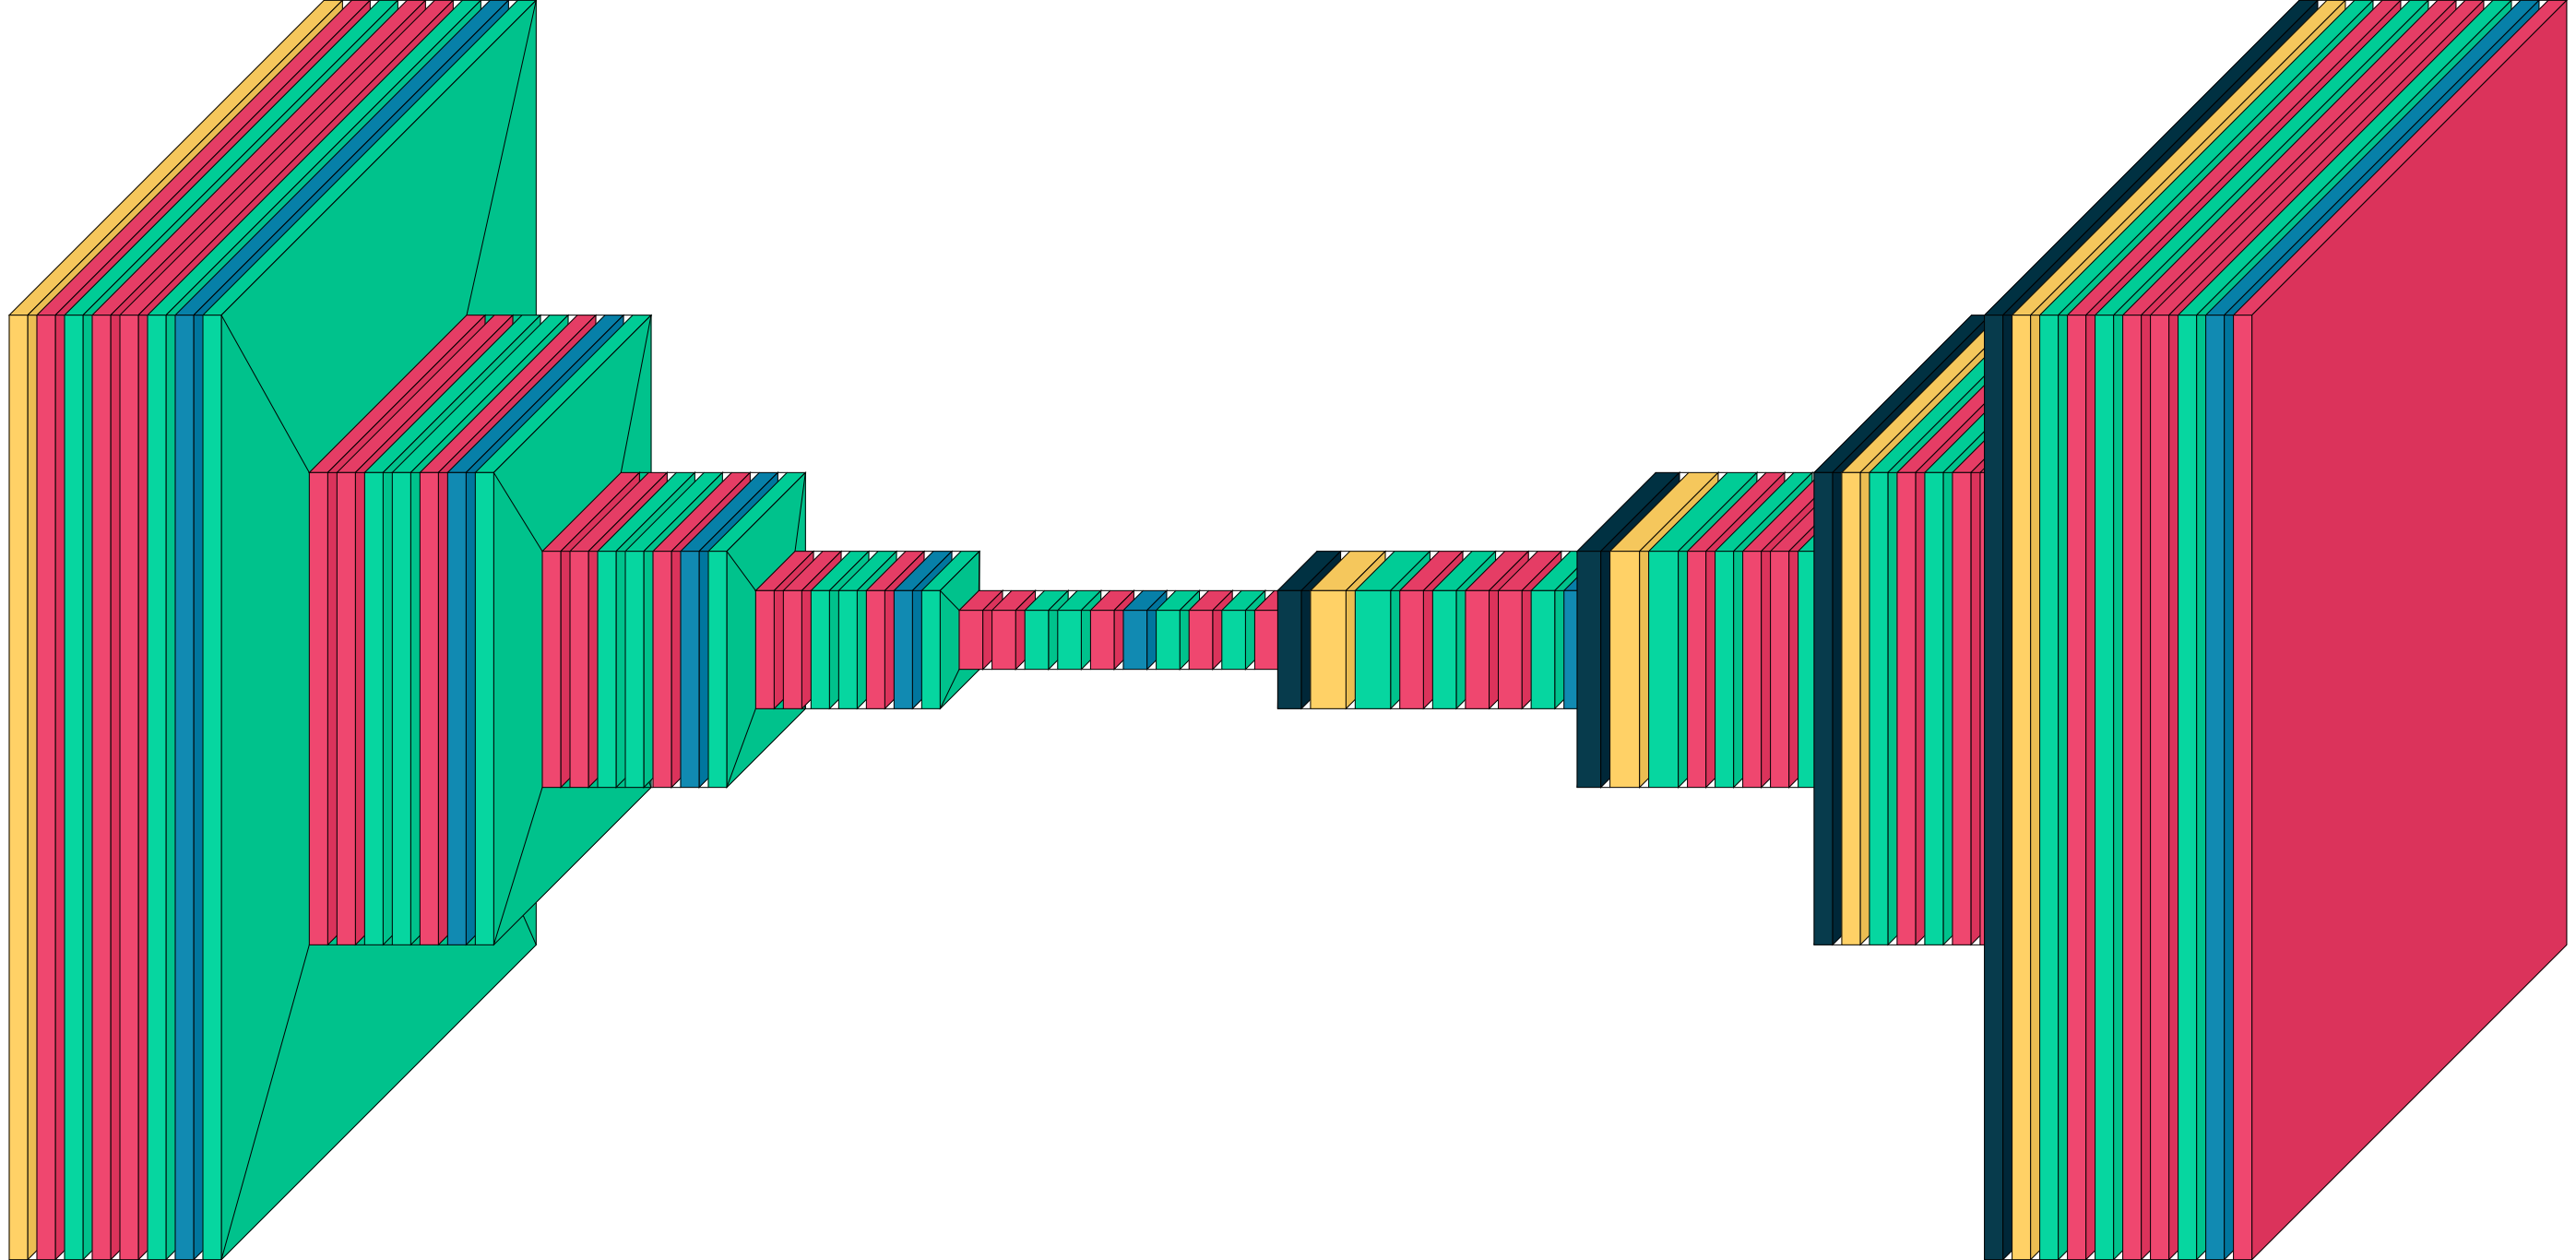

In [14]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-ResUnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Acc")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
model.load_weights('model-ResUnet.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
# Predict on train, val and test
y_pred = model.predict(X1, verbose=1)
# Threshold predictions
y_pred_t = (y_pred > 0.5).astype(np.uint8)

cls_pred_resunet_site3 = emp.merge_patches(y_pred_t, indices1, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_resunet_site3,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (RESNET) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

proj=roi_ds1.GetProjection()
geotrans=list(roi_ds1.GetGeoTransform())
bandnames=['site3']
imagename='Site3RESUNET_WHmap.tif'
CreateGeoTiff(imagename, np.squeeze(cls_pred_resunet_site3),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)





In [ ]:

X2, indices2 = emp.extract_patches(dronedata2[:, :, :5], patchsize=sample_size, overlap=0)


X2=np.array(X2)



y2_pred = model.predict(X2, verbose=1)
# Threshold predictions
y2_pred_t = (y2_pred > 0.5).astype(np.uint8)

cls_pred_resunet_site2 = emp.merge_patches(y2_pred_t, indices2, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_resunet_site2,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (resunet) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

proj=roi_ds2.GetProjection()
geotrans=list(roi_ds2 .GetGeoTransform())
bandnames=['site2']
imagename='Site2resunet_WHmap.tif'
CreateGeoTiff(imagename, np.squeeze(cls_pred_resunet_site2),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)




# Define SegNet Model with indices pooling architecture


In [ ]:
from keras import backend as K
from keras.layers import Layer


class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')
            batch_shape = K.concatenate(
                    [[input_shape[0]], [1], [1], [1]],
                    axis=0)
            batch_range = K.reshape(
                    tf.range(output_shape[0], dtype='int32'),
                    shape=batch_shape)
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = tf.range(output_shape[3], dtype='int32')
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)
            indices = K.transpose(K.reshape(
                K.stack([b, y, x, f]),
                [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [ ]:

def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    # pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)
    pool_1 = MaxPooling2D(pool_size)(conv_2)


    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    # pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)
    pool_2 = MaxPooling2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    # pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)
    pool_3 = MaxPooling2D(pool_size)(conv_7)
    
    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    #pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)
    pool_4 = MaxPooling2D(pool_size)(conv_10)
    
    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    #pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    pool_5 = MaxPooling2D(pool_size)(conv_13)
    print("Build encoder done..")

    # decoder

    # unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])
    unpool_1 = UpSampling2D(pool_size)(pool_5)

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    #unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])
    unpool_2= UpSampling2D(pool_size)(conv_16)


    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    #unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])
    unpool_3= UpSampling2D(pool_size)(conv_19)

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    #unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])
    unpool_4= UpSampling2D(pool_size)(conv_22)

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    #unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])
    unpool_5= UpSampling2D(pool_size)(conv_24)

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    #old
    #conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    #conv_26 = BatchNormalization()(conv_26)
    #conv_26 = Reshape(
    #        (input_shape[0]*input_shape[1], n_labels),
    #        input_shape=(input_shape[0], input_shape[1], n_labels))(conv_26)

    #outputs = Activation(output_mode)(conv_25)
    print("Build decoder done..")

    #conv = Conv2D(1,(1, 1),strides=(1, 1), padding='same')(block10)
    #conv_reshape = Reshape((512*512,1))(conv)
    #outputs = Activation('softmax')(block10)
    outputs = Convolution2D(1, (1, 1),padding='same', activation='sigmoid')(conv_25)

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model






    
    
    

# Compile and Summarize Model


In [ ]:
#input_img = Input((im_height, im_width, 1), name='img')
model = segnet(input_shape=(sample_size, sample_size, Nchannels),n_labels=1)

#model.summary()
from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy',dice_coef,f1_score]) 


metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()


In [ ]:

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-segnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("segnet.csv"),
    TensorBoard(log_dir='./logs')
]



In [ ]:
model.summary()

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

In [ ]:


df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result



In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Acc")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:

# load the best model
model.load_weights('model-segnet.h5')


In [ ]:
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy',dice_coef,f1_score,_recall,_precision]) 


In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
eval = model.evaluate(X_test, y_test, verbose=1)
print("Dice Loss: "+str(eval[0]))
print("Dice co-efficient: "+str(eval[1]))
print("Accuracy : "+str(eval[2]))
print("f1_score : "+str(eval[3]))
print("recall : "+str(eval[4]))
print("_recall : "+str(eval[5]))

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
# Predict on train, val and test
y_pred = model.predict(X1, verbose=1)
# Threshold predictions
y_pred_t = (y_pred > 0.5).astype(np.uint8)

cls_pred_segnet_site3 = emp.merge_patches(y_pred_t, indices1, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_segnet_site3,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (SEGNET) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

proj=roi_ds1.GetProjection()
geotrans=list(roi_ds1.GetGeoTransform())
bandnames=['site3']
imagename='Site3segnet_WHmap.tif'
CreateGeoTiff(imagename, np.squeeze(cls_pred_segnet_site3),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)





In [ ]:

X2, indices2 = emp.extract_patches(dronedata2[:, :, :5], patchsize=sample_size, overlap=0)


X2=np.array(X2)



y2_pred = model.predict(X2, verbose=1)
# Threshold predictions
y2_pred_t = (y2_pred > 0.5).astype(np.uint8)

cls_pred_segnet_site2 = emp.merge_patches(y2_pred_t, indices2, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_segnet_site2,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (SEGNET) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

proj=roi_ds2.GetProjection()
geotrans=list(roi_ds2 .GetGeoTransform())
bandnames=['site2']
imagename='Site2SEGNET_WHmap.tif'
CreateGeoTiff(imagename, np.squeeze(cls_pred_segnet_site2),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)




In [ ]:

    
    

def Segnet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    #Encoder
    # 224x224
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # 112x112
    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # 56x56
    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # 28x28
    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    # 14x14

    # decode
    up7 = UpSampling2D(size=(2, 2))(pool4)
    #up7 = concatenate([up7, conv4], axis=-1)
    conv7 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    #up8 = concatenate([up8, conv3], axis=-1)
    conv8 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    #up9 = concatenate([up9, conv2], axis=-1)
    conv9 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    up10 = UpSampling2D(size=(2, 2))(conv9)
    #up10 = concatenate([up10, conv1], axis=-1)
    conv10 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding='same')(up10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)
    conv11 = Conv2D(1, (1, 1), padding='same')(conv10)
    #uconv11 = (Reshape((outputHeight*outputWidth, nClasses)))(conv11)
    outputs = Activation('softmax')(conv11)

    model = Model(inputs=[input_img], outputs=[outputs])
    
   
    
	
    return model


 


In [ ]:
WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = tf.keras.layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = tf.keras.layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def relu6(x):
    return relu(x, max_value=6)


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1]  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2',
              OS=16, alpha=1., activation=None):
    """ Instantiates the Deeplabv3+ architecture
    Optionally loads weights pre-trained
    on PASCAL VOC or Cityscapes. This model is available for TensorFlow only.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc),
            'cityscapes' (pre-trained on cityscape) or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images. None is allowed as shape/width
        classes: number of desired classes. PASCAL VOC has 21 classes, Cityscapes has 19 classes.
            If number of classes not aligned with the weights used, last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        activation: optional activation to add to the top of the network.
            One of 'softmax', 'sigmoid' or None
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone. Pretrained is only available for alpha=1.
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """

    if not (weights in {'pascal_voc', 'cityscapes', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                         '(pre-trained on PASCAL VOC)')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation('relu')(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation('relu')(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same',
                   use_bias=False, name='Conv')(img_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = Lambda(lambda x: tf.compat.v1.image.resize(x, size_before[1:3],
                                                    method='bilinear', align_corners=True))(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        size_before2 = tf.keras.backend.int_shape(x)
        x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,
                                                        size_before2[1:3] * tf.constant(OS // 4),
                                                        method='bilinear', align_corners=True))(x)

        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation('relu')(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if (weights == 'pascal_voc' and classes == 21) or (weights == 'cityscapes' and classes == 19):
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,
                                                    size_before3[1:3],
                                                    method='bilinear', align_corners=True))(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    if activation in {'softmax', 'sigmoid'}:
        x = tf.keras.layers.Activation(activation)(x)

    model = Model(inputs, x, name='deeplabv3plus')

    # load weights

    if weights == 'pascal_voc':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_X,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_MOBILE,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    elif weights == 'cityscapes':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_X_CS,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_MOBILE_CS,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    return model

def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return preprocess_input(x, mode='tf')

In [ ]:


model = Deeplabv3(weights=None, input_tensor=None, input_shape=(sample_size, sample_size, Nchannels), classes=1, backbone='mobilenetv2',
              OS=16, alpha=1., activation='sigmoid')
model.summary()



In [ ]:


callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-monuseg-deeplabv3.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("deeplabv3.csv"),
    TensorBoard(log_dir='./logs')
]



In [ ]:
from keras import backend as K
K.clear_session()

from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D



model = Deeplabv3(weights=None, input_tensor=None, input_shape=(sample_size, sample_size, Nchannels), classes=1, backbone='mobilenetv2',
              OS=16, alpha=1., activation='sigmoid')


metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

In [ ]:


df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result



In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Acc")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:


# load the best model
model.load_weights('model-monuseg-deeplabv3.h5')


In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
eval = model.evaluate(X_test, y_test, verbose=1)
print("Dice Loss: "+str(eval[0]))
print("Dice co-efficient: "+str(eval[1]))
print("Accuracy : "+str(eval[2]))

In [ ]:
# Predict on train, val and test
preds_test = model.predict(X_test, verbose=1)

In [ ]:
# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)


In [ ]:
#prediction on test set
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t)

In [ ]:
plot_sample(X_test, y_test, preds_test, preds_test_t)

In [ ]:
plot_sample(X_test, y_test, preds_test, preds_test_t)

In [ ]:
# Predict on train, val and test
y_pred = model.predict(X1, verbose=1)
# Threshold predictions
y_pred_t = (y_pred > 0.5).astype(np.uint8)

cls_pred_deeplapv3_site3 = emp.merge_patches(y_pred_t, indices1, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_deeplapv3_site3,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (UNET) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

proj=roi_ds1.GetProjection()
geotrans=list(roi_ds1.GetGeoTransform())
bandnames=['site3']
imagename='Site3DeeplapV3_WHmap.tif'
CreateGeoTiff(imagename, np.squeeze(cls_pred_deeplapv3_site3),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)





In [ ]:

X2, indices2 = emp.extract_patches(dronedata2[:, :, :5], patchsize=sample_size, overlap=0)


X2=np.array(X2)



y2_pred = model.predict(X2, verbose=1)
# Threshold predictions
y2_pred_t = (y2_pred > 0.5).astype(np.uint8)

cls_pred_deeplapv3_site2 = emp.merge_patches(y2_pred_t, indices2, mode='max') # or

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
pos=ax1.imshow(cls_pred_deeplapv3_site2,cmap=cmap, interpolation='none'); 
ax1.set_title('Prediction Map of WH (UNET++) ',fontsize=10)

ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

proj=roi_ds2.GetProjection()
geotrans=list(roi_ds2 .GetGeoTransform())
bandnames=['site2']
imagename='Site2DeeplapV3_WHmap.tif'
CreateGeoTiff(imagename, np.squeeze(cls_pred_deeplapv3_site2),gdal.GDT_Byte,0,bandnames,GeoT=geotrans,Projection=proj)


